In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import time

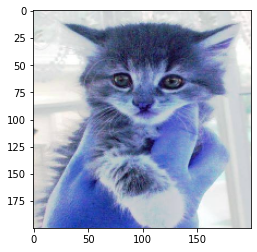

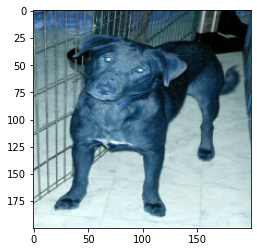

In [125]:
img_cat = cv2.resize(cv2.imread("CatsvsDogs/Train/Cats/cat.100.jpg"),(200,200))
img_dog = cv2.resize(cv2.imread("CatsvsDogs/Train/Dogs/dog.1.jpg"),(200,200))
plt.imshow(img_cat)
plt.show()
plt.imshow(img_dog)
plt.show()

In [126]:
list_img_cats_train = glob.glob("CatsvsDogs/Train/Cats/*.jpg")
list_img_dogs_train = glob.glob("CatsvsDogs/Train/Dogs/*.jpg")
list_img_cats_test = glob.glob("CatsvsDogs/Test/Cats/*.jpg")
list_img_dogs_test = glob.glob("CatsvsDogs/Test/Dogs/*.jpg")

print("Training data shape :")
print(len(list_img_cats_train))
print(len(list_img_dogs_train))
print("Testing data shape :")
print(len(list_img_cats_test))
print(len(list_img_dogs_test))

Training data shape :
200
200
Testing data shape :
25
25


In [127]:
img_x_cats_train = np.array([cv2.resize(cv2.imread(cat),(200,200)) for cat in list_img_cats_train])
img_x_dogs_train = np.array([cv2.resize(cv2.imread(dog),(200,200)) for dog in list_img_dogs_train])
img_y_cats_train = np.ones((1,len(list_img_cats_train)), dtype='int64')
img_y_dogs_train = np.zeros((1,len(list_img_dogs_train)), dtype = 'int64')

img_x_cats_test = np.array([cv2.resize(cv2.imread(cat),(200,200)) for cat in list_img_cats_test])
img_x_dogs_test = np.array([cv2.resize(cv2.imread(dog),(200,200)) for dog in list_img_dogs_test])
img_y_cats_test = np.ones((1,len(list_img_cats_test)), dtype='int64')
img_y_dogs_test= np.zeros((1,len(list_img_dogs_test)), dtype = 'int64')

In [128]:
training_x_concatenated = np.concatenate((img_x_cats_train,img_x_dogs_train), axis = 0)
test_x_concatenated = np.concatenate((img_x_cats_test,img_x_dogs_test), axis = 0)
training_y_concatenated = np.concatenate((img_y_cats_train,img_y_dogs_train), axis = 1)
test_y_concatenated = np.concatenate((img_y_cats_test,img_y_dogs_test), axis = 1)

In [129]:
print("Training data shape :")
print("Train X shape :")
print(training_x_concatenated.shape)
print("Train Y shape :")
print(training_y_concatenated.shape)
print("="*50)
print("Testing data shape :")
print("Test X shape :")
print(test_x_concatenated.shape)
print("Test Y shape :")
print(test_y_concatenated.shape)

Training data shape :
Train X shape :
(400, 200, 200, 3)
Train Y shape :
(1, 400)
Testing data shape :
Test X shape :
(50, 200, 200, 3)
Test Y shape :
(1, 50)


In [67]:
def parameters_initialization(layers):
    np.random.seed(3)
    parameter = {}
    len_layers = len(layers)
    for l in range(1,len_layers):
        parameter["W"+str(l)] = np.random.randn(layers[l],layers[l-1])*np.sqrt(2/layers[l-1])
        parameter["b"+str(l)] = np.zeros((layers[l],1))
    return parameter
        
def sigmoid(Z):
    val = 1/(1+np.exp(-Z))
    return val, Z

def relu(Z):
    val = np.maximum(0,Z)
    return val, Z

def sigmoid_backward(dA, cache):
    
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)
    return dZ

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    return  dZ

def forward_prop_linear(A_prev, W, b):
    Z = np.dot(W,A_prev) + b
    caches = (A_prev, W, b)
    return Z, caches

def forward_prop_activation(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        Z, linear_caches = forward_prop_linear(A_prev,W,b)
        A, activation_caches = sigmoid(Z)
        
    elif activation == "relu":
        Z, linear_caches = forward_prop_linear(A_prev,W,b)
        A, activation_caches = relu(Z)
    caches = (linear_caches,activation_caches)
    return A , caches

def L_forward_prop(X, parameters):
    caches = []
    A = X
    layers = len(parameters) // 2
    
    for i in range(1, layers):
        A_prev = A
        A, cache = forward_prop_activation(A_prev, parameters["W"+str(i)], parameters["b"+str(i)], activation = "relu")
        caches.append(cache)
    
    AL, cache = forward_prop_activation(A, parameters["W"+str(i+1)], parameters["b"+str(i+1)], activation = "sigmoid")
    caches.append(cache)
    
    return AL, caches
    
def compute_cost(AL, Y):
    
    m = Y.shape[1]
    cost = np.squeeze(-(np.sum(np.multiply(Y,np.log(AL)) + np.multiply((1-Y),np.log(1-AL))))/m)
    return cost

def back_prop_linear(dZ, caches):
    A_prev, W, b = caches
    m = A_prev.shape[1]
    dW = (np.dot(dZ, A_prev.T))/m
    db = np.sum(dZ,axis = 1, keepdims= True)/m
    dA_prev = np.dot(W.T,dZ)
    
    return  dA_prev, dW, db

def back_prop_activation(dA, cache, activation):
    
    linear_cache, activation_cache = cache
    
    if activation == "sigmoid":
        dZ  = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = back_prop_linear(dZ, linear_cache)
        
    elif activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = back_prop_linear(dZ, linear_cache)
        
    return dA_prev, dW, db

def L_back_prob(Y, AL, caches):
    
    grads = {}
    m = Y.shape[1]
    L = len(caches)
    Y = Y.reshape(AL.shape)
    
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[L-1]
    d_A_prev_temp, dW_temp, db_temp = back_prop_activation(dAL, current_cache, activation = "sigmoid")
    grads["dA"+ str(L-1)] = d_A_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    for i in  reversed(range(L-1)):
        current_cache = caches[i]
        d_A_prev_temp, dW_temp, db_temp = back_prop_activation(grads["dA"+ str(i+1)], current_cache, activation = "relu")
        grads["dA"+ str(i)] = d_A_prev_temp
        grads["dW" + str(i+1)] = dW_temp
        grads["db" + str(i+1)] = db_temp
        
    return grads

def update_parameters(params, grads, learning_rate):
    parameters = params.copy()
    L = len(params)//2
    
    for l in range(1, L+1):
        parameters["W"+str(l)] = params["W"+str(l)] - learning_rate*grads["dW"+str(l)]
        parameters["b"+str(l)] = params["b"+str(l)] - learning_rate*grads["db"+str(l)]
    
    return parameters

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    #(≈ 1 line of code)
    # parameters = ...
    # YOUR CODE STARTS HERE
    parameters = parameters_initialization(layers_dims)
    # YOUR CODE ENDS HERE
    
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        #(≈ 1 line of code)
        # AL, caches = ...
        # YOUR CODE STARTS HERE
        AL, caches = L_forward_prop(X, parameters)
        # YOUR CODE ENDS HERE
        
        # Compute cost.
        #(≈ 1 line of code)
        # cost = ...
        # YOUR CODE STARTS HERE
        
        cost = compute_cost(AL,Y)
        
        # YOUR CODE ENDS HERE
    
        # Backward propagation.
        #(≈ 1 line of code)
        # grads = ...    
        # YOUR CODE STARTS HERE
        grads = L_back_prob(Y,AL,caches)
        # YOUR CODE ENDS HERE
 
        # Update parameters.
        #(≈ 1 line of code)
        # parameters = ...
        # YOUR CODE STARTS HERE
        parameters = update_parameters(parameters, grads, learning_rate)
        # YOUR CODE ENDS HERE
                
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

In [130]:
training_x_flatten = training_x_concatenated.reshape(training_x_concatenated.shape[0],-1).T
test_x_flatten = test_x_concatenated.reshape(test_x_concatenated.shape[0],-1).T
print("Training data shape :")
print("Train X shape :")
print(training_x_flatten.shape)
print("Train Y shape :")
print(test_x_flatten.shape)

Training data shape :
Train X shape :
(120000, 400)
Train Y shape :
(120000, 50)


In [131]:
train_x = training_x_flatten/225
train_y = training_y_concatenated.copy()
test_x = test_x_flatten/225
test_y = test_y_concatenated.copy()

In [132]:
print("Training data shape :")
print(f"X shape = {train_x.shape}")
print(f"Y shape = {train_y.shape}")
print("Testing data shape :")
print(f"X shape = {test_x.shape}")
print(f"Y shape = {test_y.shape}")

Training data shape :
X shape = (120000, 400)
Y shape = (1, 400)
Testing data shape :
X shape = (120000, 50)
Y shape = (1, 50)


In [115]:
start = time.time()
layers_dims = [120000,500,500,250,250,50,50,10,5,1] # 3 layers
parameters, cost = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.001, num_iterations = 1000, print_cost= True)
end = time.time()
print(F"The time of execution of above program is : {(end-start)/60} minutes.")

Cost after iteration 0: 0.7804497430796566
Cost after iteration 100: 0.5827352756462093
Cost after iteration 200: 0.49905035074741466
Cost after iteration 300: 0.2884139180218799
Cost after iteration 400: 0.13974968103549215
Cost after iteration 500: 0.0515246949229051
Cost after iteration 600: 0.027877912002114355
Cost after iteration 700: 0.018287068584722885
Cost after iteration 800: 0.013181923123367238
Cost after iteration 900: 0.010100653237328241
Cost after iteration 999: 0.008092258168300314
The time of execution of above program is : 16.514980455239613 minutes.


In [116]:
def accuracy_score(y_true, y_pred):
    m = len(y_pred)
    correct = len(y_pred[y_pred == y_true])
    accuracy = correct/m
    return accuracy

In [117]:
AL, cache = L_forward_prop(train_x,parameters)
y_pred_train = np.round(np.squeeze(AL)).astype('int64')
y_true_train = np.squeeze(train_y)
accuracy = accuracy_score(y_true_train,y_pred_train)
print(f"Accuracy score = {accuracy}")

Accuracy score = 1.0


In [118]:
AL, cache = L_forward_prop(test_x,parameters)
y_pred_test = np.round(np.squeeze(AL)).astype('int64')
y_true_test = np.squeeze(test_y)
accuracy = accuracy_score(y_true_test,y_pred_test)
print(f"Accuracy score = {accuracy}")

Accuracy score = 0.52
